In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import roc_curve, auc
import warnings
import joblib

warnings.filterwarnings("ignore", message="Do not pass an `input_shape`/`input_dim` argument to a layer")

# Chargement des données prétraitées
df = pd.read_csv('data/processed/data.csv', sep='\t')
df = df.astype(int)

# Séparation des features et de la variable cible
X = df.drop('grav_grave', axis=1)
y = df['grav_grave']

# Division en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [2]:
# Obtenir le nombre correct de features
input_shape = X_train_scaled.shape[1]

# Fonction pour construire le modèle Keras
def create_model(optimizer='adam', init='glorot_uniform'):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,), kernel_initializer=init),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_initializer=init),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_initializer=init),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Création d'un wrapper KerasClassifier pour utiliser GridSearchCV
model = KerasClassifier(
    model=create_model,
    verbose=0,
    optimizer='adam',
    epochs=50,
    batch_size=32,
    model__init='glorot_uniform'
)

# Définition des hyperparamètres à tester avec GridSearchCV
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 50],
    'optimizer': ['adam', 'rmsprop'],
    'model__init': ['he_normal', 'he_uniform']
}

# Configuration de GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Entraînement du modèle avec recherche des hyperparamètres
grid_result = grid.fit(X_train_scaled, y_train)

# Affichage des meilleurs paramètres et score
print(f"Best score: {grid_result.best_score_:.4f}, using Best parameters: {grid_result.best_params_}")
print()

# Sauvegarder le meilleur modèle et le scaler
best_model_filename = 'best_model_DP.joblib'
scaler_filename = 'scaler_DP.joblib'
joblib.dump(grid_result.best_estimator_, best_model_filename)
joblib.dump(scaler, scaler_filename)

# Création d'un modèle Keras avec les meilleurs paramètres
best_params = grid_result.best_params_
best_model = create_model(optimizer=best_params['optimizer'], init=best_params['model__init'])

# Entraînement du meilleur modèle
history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test_scaled)
y_pred_class = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

# Calculer et afficher le score AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nAUC-ROC Score: {roc_auc:.4f}")

Best score: 0.7820, using Best parameters: {'batch_size': 32, 'epochs': 50, 'model__init': 'he_uniform', 'optimizer': 'rmsprop'}

Epoch 1/50
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6607 - loss: 0.6500 - val_accuracy: 0.7704 - val_loss: 0.4919
Epoch 2/50
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7670 - loss: 0.5172 - val_accuracy: 0.7740 - val_loss: 0.4922
Epoch 3/50
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7736 - loss: 0.5034 - val_accuracy: 0.7763 - val_loss: 0.4884
Epoch 4/50
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7716 - loss: 0.5028 - val_accuracy: 0.7750 - val_loss: 0.4857
Epoch 5/50
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7759 - loss: 0.5017 - val_accuracy: 0.7750 - val_loss: 0.4884
Epoch 6/50
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7758 - loss: 0.5008 - val_accuracy: 0.7761 - val_loss: 0.4942
Epoch 7/50
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7778 - loss: 0.4996 

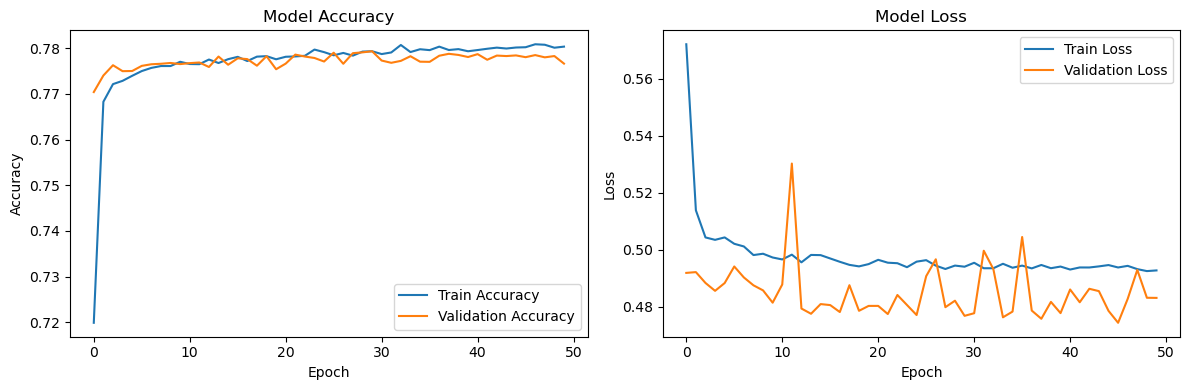

In [3]:
# Tracé de l'historique d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

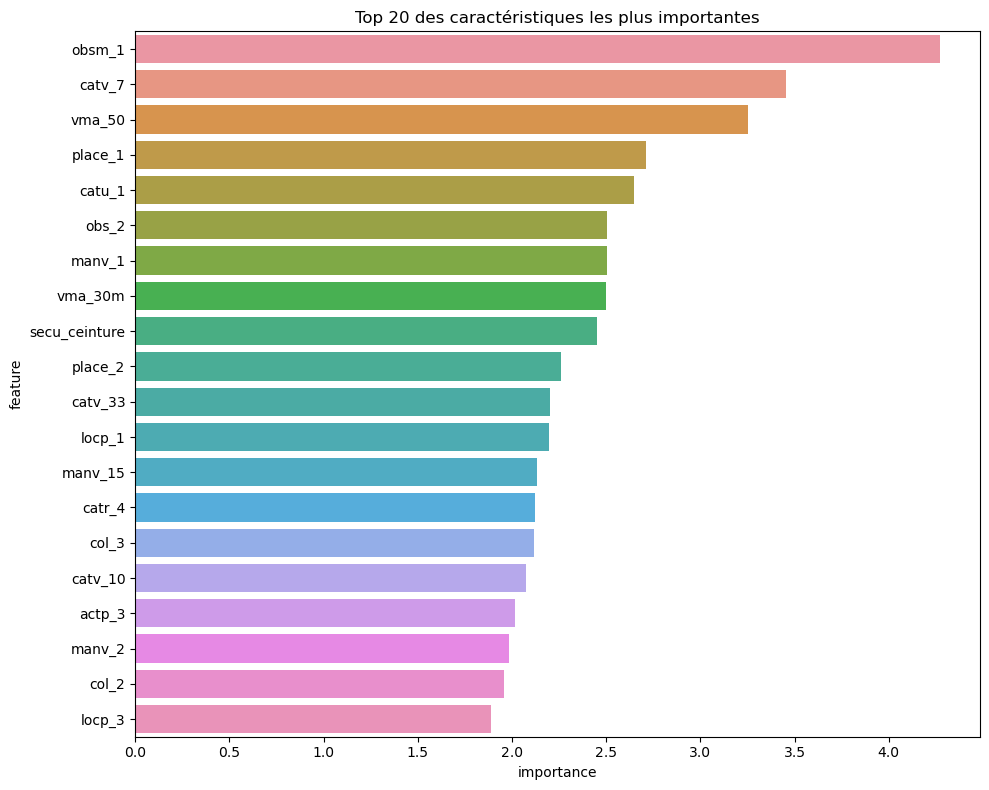

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


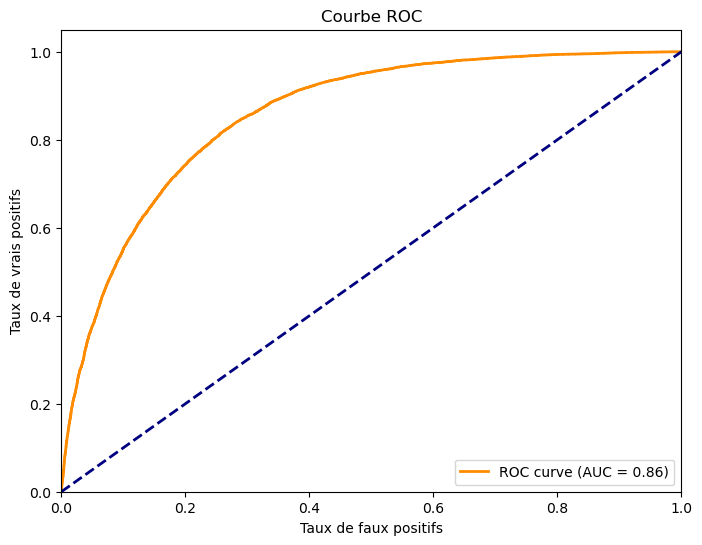

In [4]:
# Fonctions d'analyse et de visualisation

def get_feature_importance(model, feature_names):
    weights = model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)
    return dict(zip(feature_names, importance))

def plot_feature_importance(importance_dict, top_n=20):
    feature_importance = pd.DataFrame({'feature': list(importance_dict.keys()), 'importance': list(importance_dict.values())})
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Top {top_n} des caractéristiques les plus importantes')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

# Utilisation des fonctions d'analyse et de visualisation

# Importance des features
importance_dict = get_feature_importance(best_model, X.columns)
plot_feature_importance(importance_dict)

# Courbe ROC
y_pred_proba = best_model.predict(X_test_scaled).ravel()
plot_roc_curve(y_test, y_pred_proba)

  0%|          | 0/100 [00:00<?, ?it/s]

Shape of shap_values: (100, 264)
Shape of X_test_sample: (100, 264)


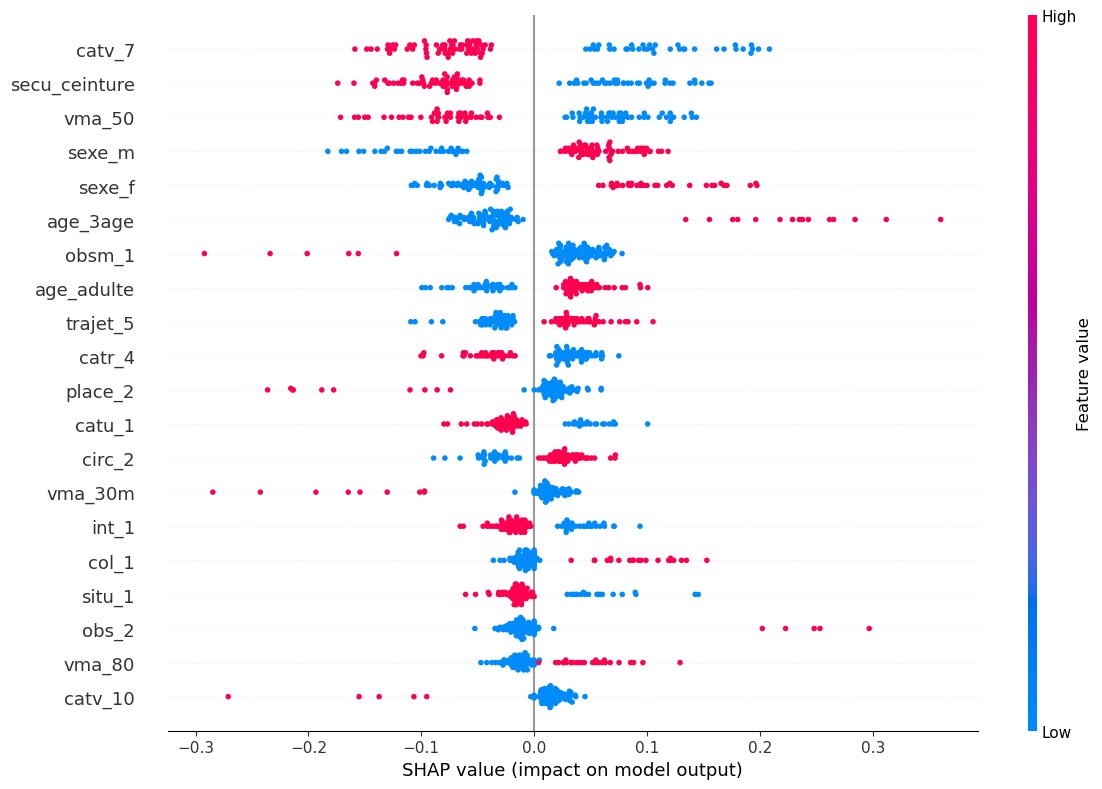

In [5]:
import shap

# Charger le meilleur modèle
best_model = joblib.load('best_model_DP.joblib')

# Définir une fonction de prédiction pour le KernelExplainer
def f(X):
    return best_model.predict(X)

# Créer un explainer SHAP
background = shap.sample(X_train_scaled, 100)  # Échantillon de background
explainer = shap.KernelExplainer(f, background)

# Calculer les valeurs SHAP pour un sous-ensemble de l'ensemble de test
sample_size = min(100, X_test_scaled.shape[0])  # Prendre au maximum 100 échantillons
X_test_sample = X_test_scaled[:sample_size]

shap_values = explainer.shap_values(X_test_sample)

# Vérifier les dimensions
print("Shape of shap_values:", np.array(shap_values).shape)
print("Shape of X_test_sample:", X_test_sample.shape)

# Ajuster shap_values pour le summary plot
shap_values_adjusted = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_values_adjusted = shap_values_adjusted.reshape(shap_values_adjusted.shape[0], -1)

# Créer un summary plot
shap.summary_plot(shap_values_adjusted, X_test_sample, feature_names=X.columns, show=False, plot_size=(12,8))
plt.savefig('shap_summary_plot.png', bbox_inches='tight')

In [6]:
shap.summary_plot(shap_values_adjusted, X_test_sample, feature_names=X.columns, show=False, plot_size=(12,8))
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.close()